In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
'''
functions to calculate parameters after liquidation
'''

# coins
def Ni(L):
    N = N0*(1-(LTVH/(2*LB)))**L
    
    if LTVH > 2*LB:
        N = 0
        
    return N

# strike price
def Ki(L):
    N = Ni(L)
    K = (N0*K0)/((2**L)*N)
    return K

# payoff
def pi(L, x):
    N = Ni(L)
    K = Ki(L)
    return N*(x - K)

# price threshold
def aH(L):
    return q/(Ni(L)*LTVH)

In [3]:
# smoot-fit function
def g(L, b):
    a = aH(L-1)
    N = Ni(L-1)
    pi_a = pi(L,a)
    pi_b = pi(L-1,b)
    return pi_b*(lambda1*(a**lambda2)*(b**(lambda1-1)) - lambda2*(a**lambda1)*(b**(lambda2-1))) - N*((a**lambda2)*(b**lambda1) - (a**lambda1)*(b**lambda2)) - pi_a*(lambda1-lambda2)*b**(lambda1+lambda2-1)

In [4]:
'''
exemplary parameters
'''
gamma  = 0.1      # contract interest
r      = 0.05     # risk-free rate
delta  = -0.0     # dividend; default: coins do not pay dividends

#r_tilde = r - gamma

sigma  = 1.03     # volatility

# paramteres for smooth-fit function
mu = - sigma/2 - (gamma - r + delta)/sigma

lambda1 = (- mu + np.sqrt(mu**2 - 2*(gamma-r)))/sigma
lambda2 = (- mu - np.sqrt(mu**2 - 2*(gamma-r)))/sigma

#lambda1 = ((- r_tilde + sigma**2/2) + np.abs(r_tilde + sigma**2/2))/sigma**2
#lambda2 = ((- r_tilde + sigma**2/2) - np.abs(r_tilde + sigma**2/2))/sigma**2

'''
contract parameters
'''
LTVH = 0.85        # threshold LTV
LB = 0.95          # liquidation bonus

N0 = 3             # initial coins
q = 6500           # initial debt
a = q/(LTVH*N0)    # liquidation threshold

LTV0 = 0.74        # initial LTV (chosen by borrower)
S0 = q/(N0*LTV0)   # starting coin price S(0)

K0 = LTV0*S0       # initial strike price

print(a, lambda1, lambda2, mu)
print(S0, K0)

2549.0196078431372 1.0 0.0942595909133754 -0.5635436893203883
2927.927927927928 2166.666666666667


In [5]:
#b = np.linspace(a+1, 11000, 20000)

L = 1               # number of liquidations
b = np.linspace(aH(L-1)+1, 11000, 20000)

nom = a**lambda2*b**lambda1 - a**lambda1*b**lambda2

In [6]:
print(Ni(L-1), Ni(L))
print(aH(L-1), aH(L))

3.0 1.657894736842105
2549.0196078431372 4612.511671335202


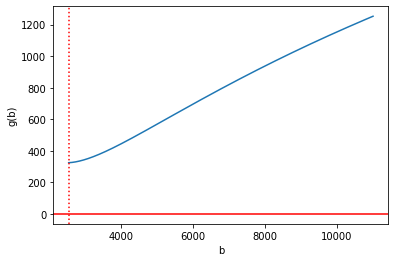

In [7]:
plt.plot(b, g(L, b))
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('b')
plt.ylabel('g(b)')
#plt.ylim(0,100)
#plt.xlim(a,4000)
plt.axvline(x=aH(L-1), color='r', linestyle=':')

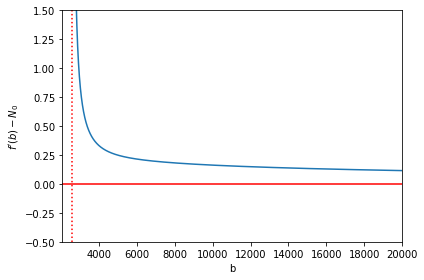

In [8]:
'''
plot of smooth-fit function with zero dividend and no drift
'''
b = np.linspace(aH(L-1)+1, 20000, 20000)
plt.plot(b, g(L, b)/nom)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('b')
#plt.ylabel(r"$f'(b)-N_{i-1}$")
plt.ylabel(r"$f'(b)-N_{0}$")
plt.ylim(-0.5,1.5)
plt.xlim(a-500,20000)
plt.axvline(x=a, color='r', linestyle=':')
#plt.savefig('g_fct_0.png', transparent=True)
plt.tight_layout()
plt.show()

In [9]:
'''
alternative (but equivalent) way of defining smooth-fit function
'''
def C1_C2(L, a, b):
    pi_a = pi(L,  a)
    pi_b = pi(L-1,b)
    
    z = np.sqrt(mu**2 - 2*(gamma - r))/sigma
    C = (b/a)**z - (a/b)**z
    
    A = b**(-z)/(C*a**(-mu/sigma))
    B = (b**z)/(C*a**(-mu/sigma))
    
    C1 = 1/C * pi_b*b**(mu/sigma)*a**(-z) - pi_a/C * (b**(-z))/(a**(-mu/sigma))
    C2 = - 1/C * pi_b*b**(mu/sigma)*a**z + pi_a/C * (b**z)/(a**(-mu/sigma))
    
    return C1, C2

def f(L, a, b):
    C1, C2 = C1_C2(L, a, b)
    return C1*b**lambda1 + C2*b**lambda2

def f_prime(L, a, b):
    C1, C2 = C1_C2(L, a, b)
    return C1*lambda1*b**(lambda1-1) + C2*lambda2*b**(lambda2-1)

C1 = 3.427433998736463
C2 = -3705.197933329873


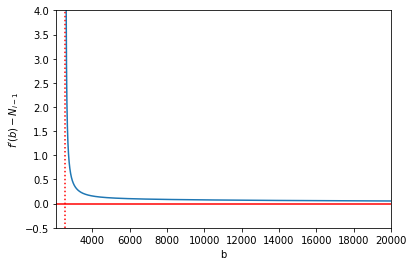

In [10]:
b = np.linspace(aH(L-1)+1, 20000, 20000)
#L = 1

plt.plot(b, f_prime(L, a, b)-Ni(L-1))
#plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('b')
plt.ylabel(r"$f'(b)-N_{i-1}$")
plt.ylim(-0.5,4)
plt.xlim(a-500,20000)
plt.axvline(x = a, color='r', linestyle=':')
plt.axhline(y = 0, color='r')

C1,C2 = C1_C2(L, a, 3500)
print(r'C1 =', C1)
print(r'C2 =', C2)

In [11]:
print(f_prime(L,a,5000)-Ni(L-1),f_prime(L,a,7000)-Ni(L-1))

0.11876109711149319 0.09324124643384657


In [12]:
# root of f_prime
gb_arr = f_prime(L,a,b)-Ni(L-1)
tar = 0
loss = (gb_arr - tar)**2
b[np.argmin(loss)]

20000.0

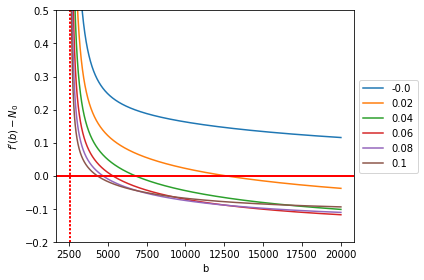

In [13]:
'''
try for different possible drifts of the underlying process
'''

b = np.linspace(aH(L-1)+1, 20000, 20000)
drift = np.linspace(0,-0.1,6)    
for d in drift:    
    mu = - sigma/2 - (gamma - r + d)/sigma

    lambda1 = (- mu + np.sqrt(mu**2 - 2*(gamma-r)))/sigma
    lambda2 = (- mu - np.sqrt(mu**2 - 2*(gamma-r)))/sigma
    
    plt.plot(b, g(L, b)/nom, label=-np.round(d,2))
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('b')
    #plt.ylabel(r"$f'(b)-N_{i-1}$")
    plt.ylabel(r"$f'(b)-N_{0}$")
    plt.ylim(-0.2,0.5)
    plt.axvline(x=a, color='r', linestyle=':')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.savefig('g_fct_drift.png', transparent=True)
    plt.tight_layout()

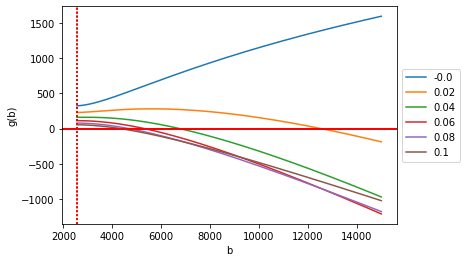

In [14]:
b = np.linspace(aH(L-1)+1, 15000, 20000)
drift = np.linspace(0,-0.1,6)    
for d in drift:
    mu = - sigma/2 - (gamma - r + d)/sigma

    lambda1 = (- mu + np.sqrt(mu**2 - 2*(gamma-r)))/sigma
    lambda2 = (- mu - np.sqrt(mu**2 - 2*(gamma-r)))/sigma
    
    plt.plot(b, g(L, b),label=-np.round(d,2))
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('b')
    plt.ylabel('g(b)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(-0.1,0.2)
    #plt.xlim(a,4000)
    plt.axvline(x=aH(L-1), color='r', linestyle=':')